# Time Series Analysis: Tutorial 6

## Import packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('text', usetex=True)
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.linear_model import LinearRegression

## Box-Jenkins Method

The Box-Jenkins Method consists of the following steps:

1. Identification
2. Estimation
3. Diagnostic Checking
4. Forecasting

The steps 2 and 3 might me reiteraded until one has found a suitable model estimate. We want to perform this procedure on a dataset which contains average house prices for the UK from January 1991 to May 2007.

Note: the steps described by Hamilton (1994, p. 109-110) are: 1. Transformation, 2. Making initial guesses of ARMA dimensions p and q, 3. Estimation of the ARMA model, 4. Daignostic analysis 

## Data

In [21]:
# Load the dta-file into a dataframe, compute the relative price change and generate a time variable.
# Put everything together into one DataFrame.
series=pd.read_stata('C:/Users/MS/Documents/TU/Teaching/TSA/06-Tutorial-6/Programming/ahp.dta')
series_relativechange=100*series.pct_change()
time = pd.date_range(start="1991-1-1", end="2007-6-1", inclusive="left", freq="M")
data = pd.DataFrame(time, columns=['date'])
ts=data.assign(ahp=series.values,ahp_relative=series_relativechange.values)

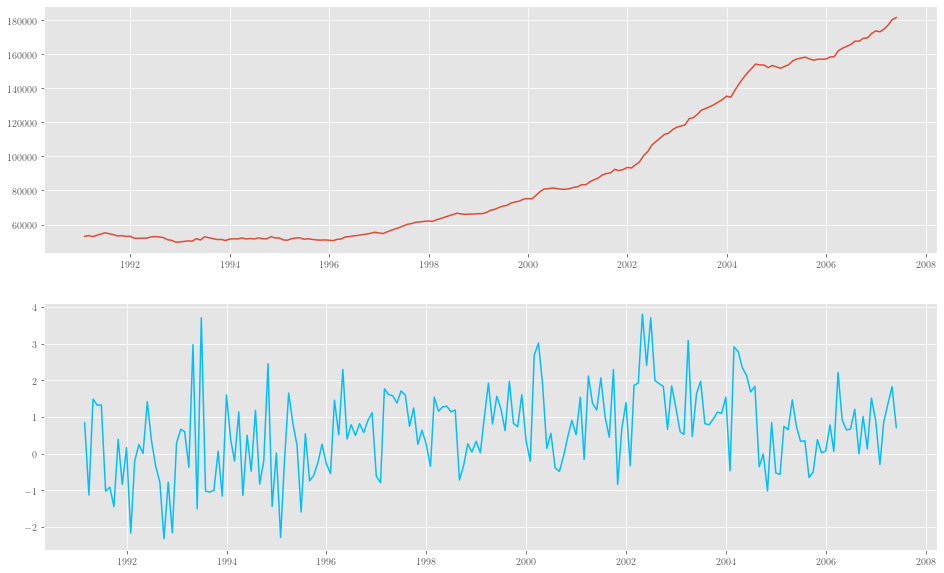

In [22]:
# Plot both series with matplotlib. The relative price changes might have to be adapted in scale.
fig, ax=plt.subplots(2,1,figsize=(16,10))
ax[0].plot(ts['date'],ts['ahp'])
ax[1].plot(ts['date'],ts['ahp_relative'],c="deepskyblue")

## 1. Identification

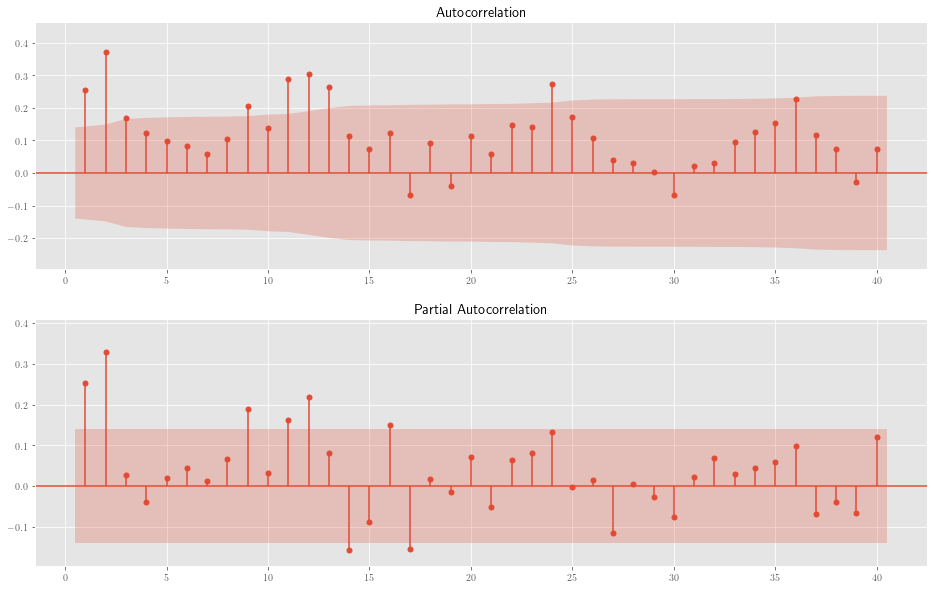

In [27]:
# Identify serial correlation via ACF and PACF.
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['ahp_relative'].values[1:], lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['ahp_relative'].values[1:], lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = "OLS")

In [6]:
# Compute the numerical values for the ACF and PACF.
r,q,p = sm.tsa.stattools.acf(ts['ahp_relative'].values[1:].squeeze(), nlags=40, fft=True, qstat=True)
pacf  = sm.tsa.stattools.pacf(ts['ahp_relative'].values[1:].squeeze(), method="OLS", nlags=40)
data  = np.c_[range(1,41), r[1:], q, p, pacf[1:]]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)", "PAC"])
print(table.set_index('lag'))

            AC           Q      Prob(>Q)       PAC
lag                                               
1.0   0.254113   12.851124  3.372766e-04  0.254118
2.0   0.370363   40.290468  1.782526e-09  0.328534
3.0   0.169835   46.090372  5.426023e-10  0.026030
4.0   0.123490   49.172727  5.373863e-10 -0.039907
5.0   0.099008   51.164448  8.003126e-10  0.019636
6.0   0.084082   52.608479  1.406780e-09  0.045009
7.0   0.059548   53.336586  3.180990e-09  0.011126
8.0   0.104794   55.603525  3.369441e-09  0.066531
9.0   0.206201   64.427418  1.864241e-10  0.188330
10.0  0.136791   68.331561  9.299166e-11  0.031086
11.0  0.288347   85.772964  1.117149e-13  0.161164
12.0  0.304300  105.303226  5.058157e-17  0.218107
13.0  0.265312  120.230579  1.812843e-19  0.080953
14.0  0.114194  123.011175  1.615780e-19 -0.157245
15.0  0.075046  124.218718  2.862647e-19 -0.089369
16.0  0.124146  127.541606  1.923998e-19  0.149179
17.0 -0.067945  128.542489  3.574383e-19 -0.155365
18.0  0.092823  130.420981  4.4

In [7]:
# Just to refresh, let's calculate the PAC for lag k=3 via an OLS regression.
y=np.array(ts['ahp_relative'].values[4:])
X=np.array([ts['ahp_relative'].values[3:-1],ts['ahp_relative'].values[2:-2],ts['ahp_relative'].values[1:-3]])
X=X.transpose()
X=sm.tools.tools.add_constant(X, prepend=True, has_constant='skip')
reg=sm.regression.linear_model.OLS(y,X)
model=reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     12.96
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           9.76e-08
Time:                        18:27:56   Log-Likelihood:                -281.68
No. Observations:                 193   AIC:                             571.4
Df Residuals:                     189   BIC:                             584.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3111      0.095      3.272      0.0

## 2. Estimation

![title](shapesARMA.png)

In [8]:
# Estimate candidate models according to ACF and PACF.
# Let's try an AR(2) and ARMA(1,1).

# AR(2) via OLS
y2=np.array(ts['ahp_relative'].values[3:])
X2=np.array([ts['ahp_relative'].values[2:-1],ts['ahp_relative'].values[1:-2]])
X2=X2.transpose()
X2=sm.tools.tools.add_constant(X2, prepend=True, has_constant='skip')
reg=sm.regression.linear_model.OLS(y2,X2)
OLS_ar12=reg.fit()
print(OLS_ar12.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     19.25
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           2.42e-08
Time:                        18:29:45   Log-Likelihood:                -283.24
No. Observations:                 194   AIC:                             572.5
Df Residuals:                     191   BIC:                             582.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3281      0.092      3.572      0.0

In [10]:
# AR(2) via ARIMA
arma1=ARIMA(ts['ahp_relative'].values[1:],order=(2,0,0))
ARMA_ar12=arma1.fit()
print(ARMA_ar12.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  196
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -286.690
Date:                Wed, 13 Dec 2023   AIC                            581.380
Time:                        18:30:24   BIC                            594.492
Sample:                             0   HQIC                           586.688
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6358      0.149      4.266      0.000       0.344       0.928
ar.L1          0.1683      0.060      2.813      0.005       0.051       0.286
ar.L2          0.3297      0.056      5.880      0.0

## Remark!

The constants are different! This is due to the fact, that via OLS one estimates the actual constant $\delta$ in $y=\delta+\alpha x_1+\beta x_2+\varepsilon$. The ARIMA command instead gives $\mu=\frac{\delta}{1-\alpha-\beta}$ as the constant, which is the unconditional mean. 

How does that come? The unconditional mean is one of the parameters specified in the likelihood function, and is used as initial value for $y_t$ when the density of the first $y_t$-observation is specified. (see the derivation in the lecture or at page 118-119 in Hamilton 1994)

Recall that: $E[y_t] = \mu =  \delta/(1 − \psi_1)$ for an AR(1). (Tutorial 4)

In [11]:
# ARMA(1,1) via ARIMA
arma2=ARIMA(ts['ahp_relative'].values[1:],order=(1,0,1))
ARMA_ar1ma1=arma2.fit()
print(ARMA_ar1ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  196
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -290.258
Date:                Wed, 13 Dec 2023   AIC                            588.516
Time:                        18:31:04   BIC                            601.628
Sample:                             0   HQIC                           593.824
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6342      0.216      2.936      0.003       0.211       1.058
ar.L1          0.9182      0.049     18.779      0.000       0.822       1.014
ma.L1         -0.7647      0.082     -9.315      0.0

## 3. Diagnostic Checking

### Diagnostic Checking: Steps 

Step 1: Does the estimation output look "good"? \
In order to investigate on the model output step back to the estimation results and investigate the parameters: are all parameters significant? If no: "restrict" the model and drop insignificant ones. 

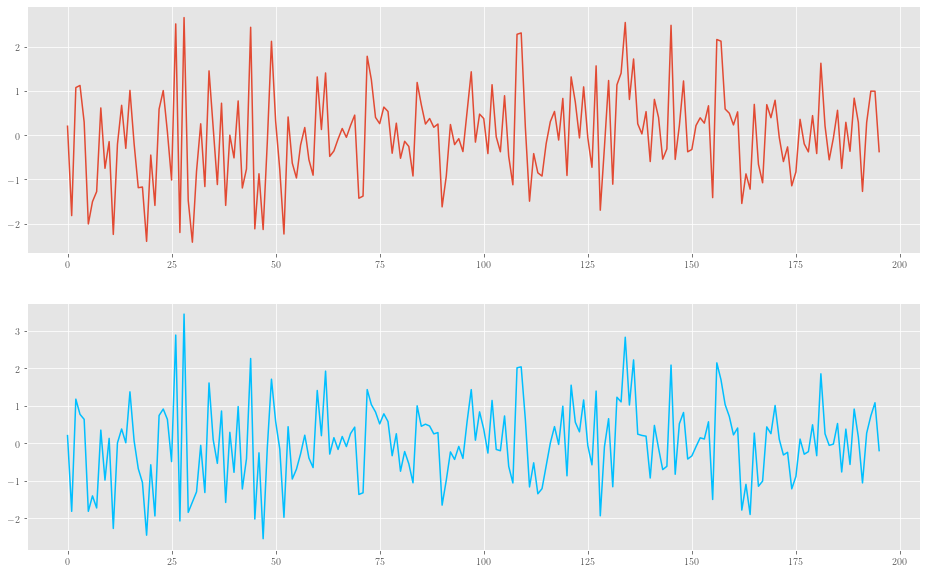

In [29]:
# Check the residuals of the AR(2) and ARMA(1,1). What should they look like?
fig, ax=plt.subplots(2,1,figsize=(16,10))
ax[0].plot(ARMA_ar12.resid)
ax[1].plot(ARMA_ar1ma1.resid,c="deepskyblue")

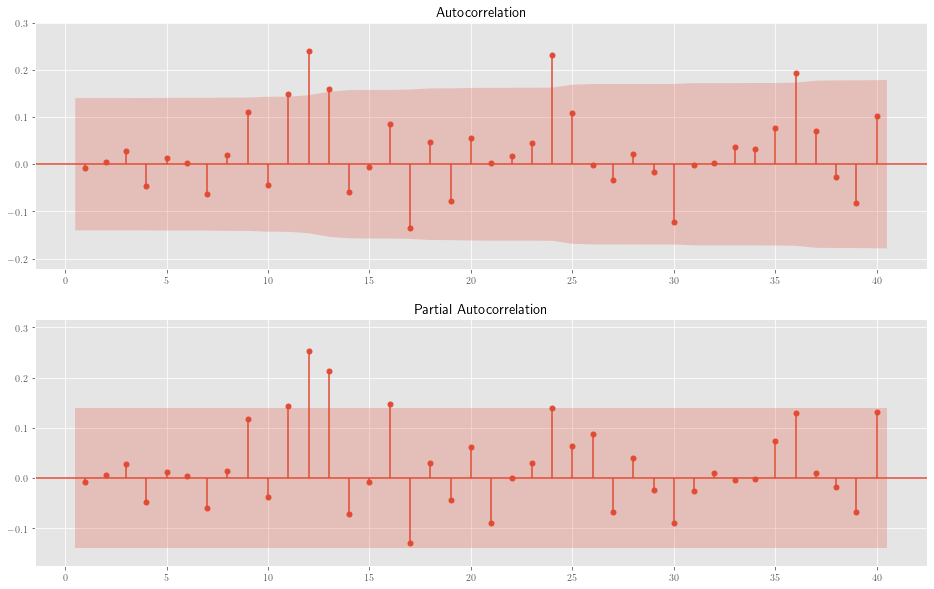

In [30]:
# Check if the residuals are still serially correlated.
# ACF and PACF of AR(2) residuals
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ARMA_ar12.resid, lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ARMA_ar12.resid, lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = "OLS")

### Diagnostic Checking: Steps 

Step 2: Do the residuals look "clean"? \
Look at the residuals: are they stationary? Do they "contain" any more serial dependency?

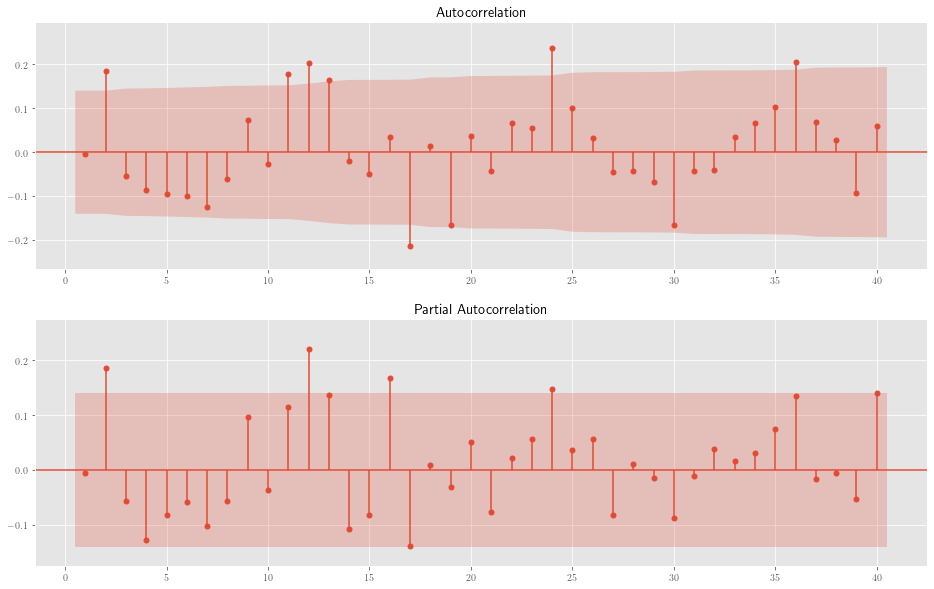

In [32]:
# ACF and PACF of ARMA(1,1)
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ARMA_ar1ma1.resid, lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ARMA_ar1ma1.resid, lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = "OLS")

In [33]:
# Significant spikes at lag k=2 suggest, that we should look for a different model.
# Let's try an ARMA(2,1)
arma3=ARIMA(ts['ahp_relative'].values[1:],order=(2,0,1))
ARMA_ar12ma1=arma3.fit()
print(ARMA_ar12ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  196
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -286.637
Date:                Tue, 19 Dec 2023   AIC                            583.273
Time:                        11:40:47   BIC                            599.664
Sample:                             0   HQIC                           589.909
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6360      0.152      4.171      0.000       0.337       0.935
ar.L1          0.2254      0.217      1.039      0.299      -0.200       0.651
ar.L2          0.3153      0.067      4.692      0.0

In [34]:
# Restrict the model by dropping the insignificant ar.L1 term.
arma4=ARIMA(ts['ahp_relative'].values[1:],order=([2],0,1))
ARMA_ar2ma1=arma4.fit()
print(ARMA_ar2ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  196
Model:               ARIMA([2], 0, 1)   Log Likelihood                -287.374
Date:                Tue, 19 Dec 2023   AIC                            582.748
Time:                        11:40:51   BIC                            595.860
Sample:                             0   HQIC                           588.056
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6353      0.135      4.704      0.000       0.371       0.900
ar.L2          0.3555      0.058      6.173      0.000       0.243       0.468
ma.L1          0.1587      0.062      2.571      0.0

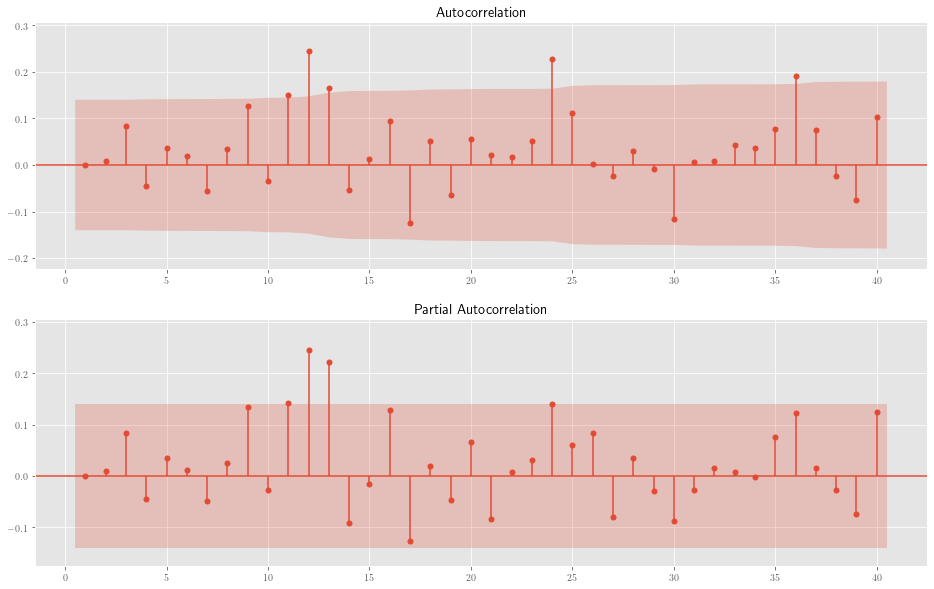

In [35]:
# Check the residuals again.
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ARMA_ar2ma1.resid, lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ARMA_ar2ma1.resid, lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method = "OLS")

## Result

The AR(2) model has AIC=581.380 and BIC=594.492.
The restricted ARMA(2,1) model has AIC=582.748 and BIC=595.860.
The AR(2) has smaller values for both, i.e. we choose it among the two candidate models. We could have taken other models into account and make the process more complex, obviously.

## 4. Forecasting

In [36]:
# Estimate the AR(2), but without the last 5 observations.
arma_reduceddata=ARIMA(ts['ahp_relative'].values[1:-5],order=(2,0,0))
ARMA_ar12_reduced=arma_reduceddata.fit()
print(ARMA_ar12_reduced.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  191
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -280.119
Date:                Tue, 19 Dec 2023   AIC                            568.238
Time:                        11:41:36   BIC                            581.247
Sample:                             0   HQIC                           573.507
                                - 191                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6292      0.154      4.094      0.000       0.328       0.930
ar.L1          0.1665      0.060      2.754      0.006       0.048       0.285
ar.L2          0.3381      0.057      5.969      0.0

In [37]:
#Compute forecasts five periods into the future.
ARMA_ar12_reduced.forecast(steps=5, exog=None, alpha=0.05)

array([0.97332517, 0.78028125, 0.77069648, 0.70382999, 0.68945284])

In [38]:
ts['ahp_relative'].values[-5:]

array([-0.29986302,  0.85495743,  1.36057147,  1.82456814,  0.7043269 ])

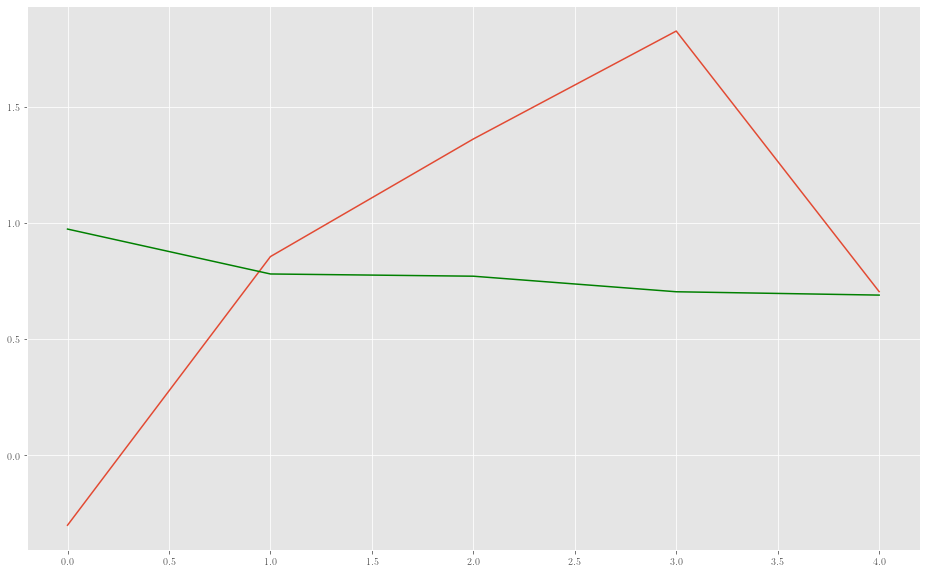

In [39]:
fig, ax=plt.subplots(figsize=(16,10))
ax.plot(ts['ahp_relative'].values[-5:])
ax.plot(ARMA_ar12_reduced.forecast(steps=5, exog=None, alpha=0.05),c='g')

Note that the forecast (green) approaches the unconditional mean, which was 0.6358.